In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
from scipy import stats, linalg
import pickle
from collections import Counter

import networkx as nx

#feature selections
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


#modelling
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from UTILS import perc_element_dico, corr_from_feature2feature, corr_from_dep2feature
import config_mobility as config

we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
title_ = '_LB_newword_def_onesession_morethan4_in11_sess_1_2_3' #'_LB', '_all','_LSL', '_LB_newword_def', '_all_newword_def'
path_save_ = os.path.join(path_extracted_data, 'visual', 'predict_KBF', title_)
path_save_LDA = os.path.join(path_extracted_data, 'visual', 'LDA', title_)
path_save_LDA_LDA = os.path.join(path_extracted_data, 'visual', 'LDA', title_,'LDA')
if not os.path.exists(path_save_LDA_LDA):
    os.makedirs(path_save_LDA_LDA)

# Download data

### timepoint info

In [4]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';',parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
df_master['day'] = df_master['day'].map(lambda x: dt.datetime.strptime(x, "%d.%m.%Y"))
df_ = df_master.groupby('timepoint')['day'].agg(lambda x: sorted(set(x))).reset_index()
dico_day_sessiontpt = {}
for tpt in df_master['timepoint'].unique():
    li_d = df_[df_['timepoint']==tpt]['day'].values[0]
    for i,d in enumerate(li_d):
        dico_day_sessiontpt[d] = 'sess_'+str(tpt)+'_day'+str(i%6) #modulo 6 to take into account groups A and B
#dico_day_sessiontpt

### hen level info

In [5]:
df_modelling = pd.read_csv(os.path.join(path_save_,'df_modelling.csv'), sep=";")
print(df_modelling.shape)
li_output = ['max_severity',
             'max_positive_rate_in_severity',
             'value_of_first_positive_rate_in_severity',
             'var_severity',
             'ratio_HealingAndNonhealing',
             "('Strength', 'variance')",
             "('Strength', 'mean')",
             "('Mass', 'variance')",
             "('Mass', 'mean')",
             "('Width', 'variance')",
             "('Width', 'mean')"]
df_modelling[['HenID']+li_output].head(3)

(57, 540)


,HenID,max_severity,max_positive_rate_in_severity,value_of_first_positive_rate_in_severity,var_severity,ratio_HealingAndNonhealing,"('Strength', 'variance')","('Strength', 'mean')","('Mass', 'variance')","('Mass', 'mean')","('Width', 'variance')","('Width', 'mean')"
0,hen_100,8.7,5.5,4.5,13.076529,0.166667,49.687500,42.750000,17.015000,63.200000,0.000600,0.320000
1,hen_101,9.8,3.6,2.5,8.417025,0.118421,6.240000,48.600000,1.240000,57.100000,0.000440,0.290000
2,hen_102,4.6,2.3,2.0,2.660165,0.393443,9.555556,49.666667,2.595556,62.666667,0.000156,0.343333


### add all topic modelling into one dataframe

In [6]:
li_dflda = []
min_topic = 2
li_path = glob.glob(os.path.join(path_extracted_data,'visual','LDA', title_, '*'))
max_topic = max([int(x.split('\\')[-1]) for x in li_path if x.split('\\')[-1].isdigit()])
df_all_lda = pd.DataFrame(columns=['day','HenID'])
for nbr_topics_ in range(min_topic,max_topic+1):
    path_save = os.path.join(path_extracted_data,'visual','LDA', title_, str(nbr_topics_))
    df_lda = pd.read_csv(os.path.join(path_save,'df_topics'+str(nbr_topics_)+'.csv'), sep=';',parse_dates=['day']) 
    #print(df_lda.shape)
    #df_lda.head(3)
    df_lda['topic'] = df_lda['topic'].map(lambda x: 'topic_'+str(x))
    #lets take the topic distribution / main topic of the clustering with k=6-15 over all the days of the first session
    li_sorted_days = df_lda.sort_values(['day'],ascending=True)['day'].unique()
    li_topics = [x for x in df_lda.columns if (x.startswith('topic')) & (x!='topic_info')]
    dico_topics_newtopics = {c:'k'+str(nbr_topics_)+'_'+ c for c in li_topics}
    df_lda.rename(columns=dico_topics_newtopics, inplace=True)
    df_all_lda = pd.merge(df_all_lda, df_lda[['HenID','day']+list(dico_topics_newtopics.values())], on=['HenID','day'], 
                          how='outer')
df_all_lda['session_day'] = df_all_lda['day'].map(lambda x: dico_day_sessiontpt.get(x,''))
df_all_lda['session'] = df_all_lda['session_day'].map(lambda x: x.split('_day')[0])
print(df_all_lda.shape)
df_all_lda.head(3)

(1046, 43)


,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,k7_topic_proba,k7_topic_0_proba,k7_topic_1_proba,k7_topic_2_proba,k7_topic_3_proba,k7_topic_4_proba,k7_topic_5_proba,k7_topic_6_proba,session_day,session
0,hen_41,2016-10-27,topic_0,0.993477,0.993477,0.000000,topic_1,0.665227,0.322157,0.665227,...,0.714943,0.0,0.040325,0.0,0.034392,0.193702,0.000000,0.714943,sess_1_day0,sess_1
1,hen_42,2016-10-27,topic_0,0.815571,0.815571,0.184429,topic_1,0.512698,0.353777,0.512698,...,0.442241,0.0,0.442241,0.0,0.064654,0.272519,0.030934,0.177898,sess_1_day0,sess_1
2,hen_43,2016-10-27,topic_0,0.994462,0.994462,0.000000,topic_1,0.866392,0.123018,0.866392,...,0.709043,0.0,0.709043,0.0,0.026582,0.157999,0.000000,0.092003,sess_1_day0,sess_1


In [7]:
li_t = [x for x in df_all_lda.columns if (x.startswith('k')) & ('proba' in x) & ('topic_proba' not in x)]
#except last one! (car sum to 1)
print(len(li_t))
li_t = [x for x in li_t if 'topic_'+str(int(x.split('_')[0][1:])-1)+'_proba' not in x]
print(len(li_t))
dico_sess_tXy = {}
#define LDA model on the first session only
df_all_lda = df_all_lda[df_all_lda['session']!='']
for sess, df_sess in df_all_lda.groupby(['session']):
    #print('------------', sess)
    #dont care about havving more or less observation per class
    df_ = df_all_lda.groupby(['HenID','session']).agg(lambda x: str(list(x))).reset_index()
    df_['nbr_day'] = df_['session_day'].map(lambda x: len(eval(x)))
    li_henid_toremove = set(df_[(df_['nbr_day']<3)&((df_['session']==sess))]['HenID'].tolist())
    print(len(li_henid_toremove))
    #print(df_sess.shape)
    df_sess = df_sess[~df_sess['HenID'].isin(li_henid_toremove)]
    X = df_sess[li_t].values
    y = df_sess['HenID'].values
    #print(X.shape, y.shape)
    dico_sess_tXy[sess] = (X,y)

27
21
0
0
0


# Linear Discriminant Analysis

In [8]:
def plot_cov_ellipse(cov, pos, color, nstd=2, ax=None):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    #width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, alpha=0.1, color=color)
    ax.add_artist(ellip)
    return ellip


def plot_scikit_lda(X, y, lda, title, path_save):
    plt.figure(figsize=(14,6))
    ax = plt.subplot(111)
    #'RdBu', 'rocket_r', 'muted', 'Set1'
    #sns.palplot(sns.color_palette("Set1", n_colors=8, desat=.5))
    for label,labelid,color in zip(set(y),range(len(set(y))),sns.color_palette("Set1", len(set(y)))):
        plt.scatter(x=X[:,0][y==label], #first LDA component e.g. X[:,0][y=='hen_100']
                    y=X[:,1][y==label], #second LDA component
                    color=color,
                    alpha=0.6,
                    label=label)
        #add ellipse TODO IF USING IT: check best way to do ellipse
        points = np.array(list(zip(X[:,0][y==label], X[:,1][y==label])))
        #plot_point_cov(points, nstd=3, alpha=0.5, color='green')
        pos = points.mean(axis=0)
        cov = np.cov(points, rowvar=False)
        #cov = lda.covariance_
        #pos = lda.means_[labelid]
        plot_cov_ellipse(cov, pos, color, 2, ax)

    #list of variance explained
    li_var = list(lda.explained_variance_ratio_)
    plt.xlabel('LD1 - percentage of explained variance: '+str(round(li_var[0]*100)))
    plt.ylabel('LD2 - percentage of explained variance: '+str(round(li_var[1]*100)))
    plt.title(title)
    
    #leg = plt.legend(loc='upper right', fancybox=True)
    #leg.get_frame().set_alpha(0.5)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    #remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.savefig(os.path.join(path_save, title+'.png'),dpi=300,format='png',bbox_inches='tight')
    #plt.show()
    
def explained_var(lda, nbr_lda_components, path_save):
    li_var = list(lda.explained_variance_ratio_)
    fig = plt.figure(figsize=(10,3.5))
    fig.suptitle('LDA explained variance (red line : %d components)'%nbr_lda_components) 
    plt.subplot(1,2,1)
    plt.plot(np.round(li_var, decimals=4)*100)
    plt.xlabel('number of LDA components')
    plt.ylabel('% of explained variance')
    plt.axvline(x=nbr_lda_components-1, linewidth=1, color='red')
    plt.subplot(1,2,2)
    plt.plot(np.cumsum(np.round(li_var, decimals=4)*100))
    plt.xlabel('number of LDA components')
    plt.ylabel('cumulative % of explained variance')
    plt.axvline(x=nbr_lda_components-1, linewidth=1, color='red')
    plt.ylim(0,105)
    plt.savefig(os.path.join(path_save, 'explained_variance.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

# LDA fit

In [9]:
#on first session
(X,y) = dico_sess_tXy['sess_1']
print(X.shape, y.shape)

(337, 21) (337,)


In [10]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X, y)
#extract the labels
li_labels = lda.classes_
li_labels[0:10]

array(['hen_100', 'hen_101', 'hen_102', 'hen_103', 'hen_104', 'hen_105',
       'hen_106', 'hen_107', 'hen_108', 'hen_109'], dtype='<U7')

In [11]:
#defined nbr comopennets to analyse
nbr_lda_components = 4

# Hens into the LDA 2Dspace - for each session

c:\users\camil\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\camil\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\camil\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\camil\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as 

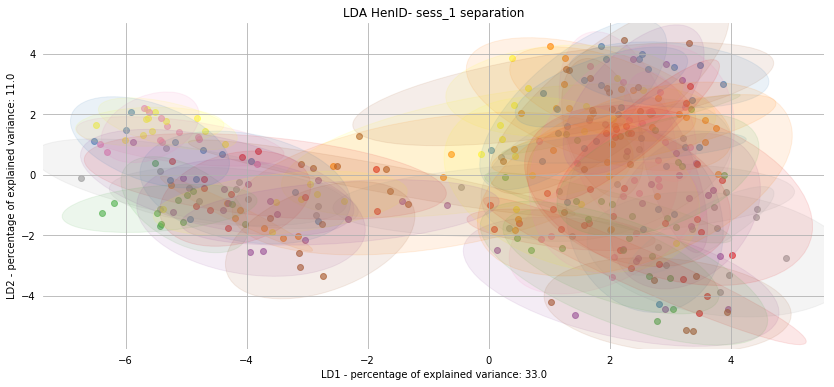

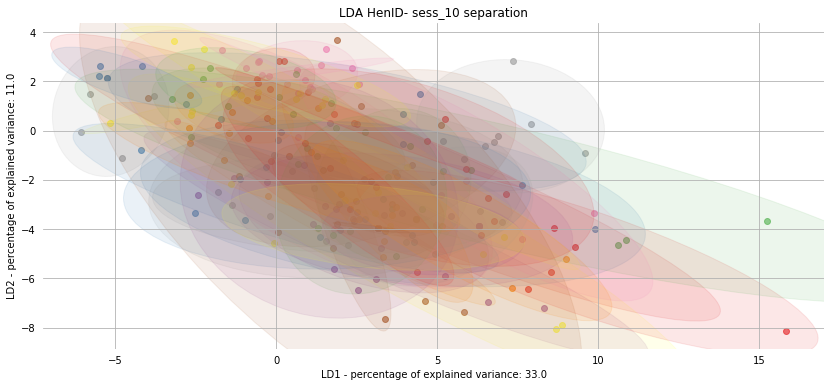

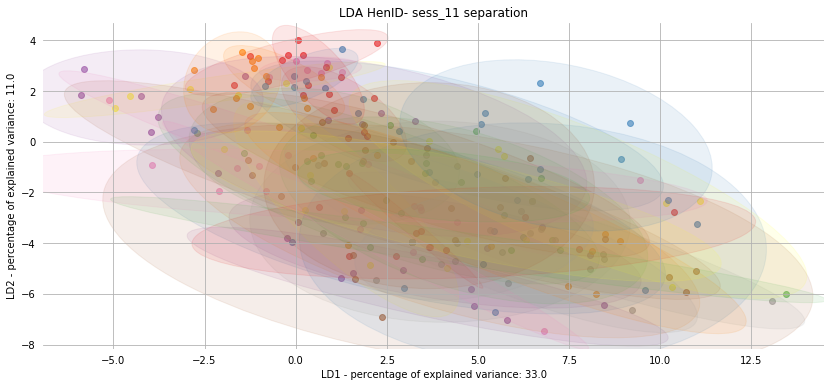

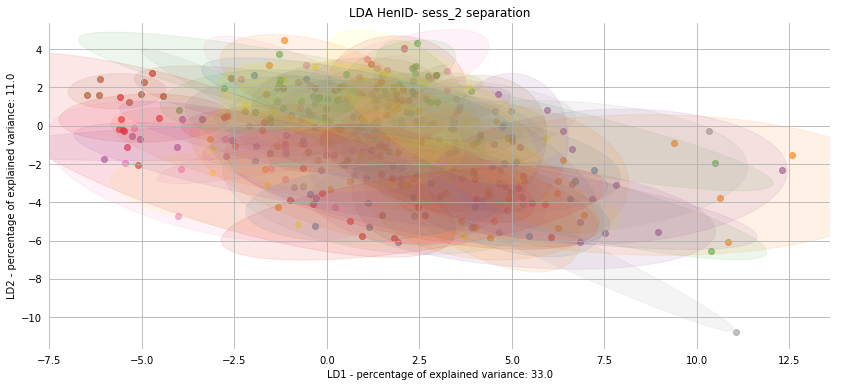

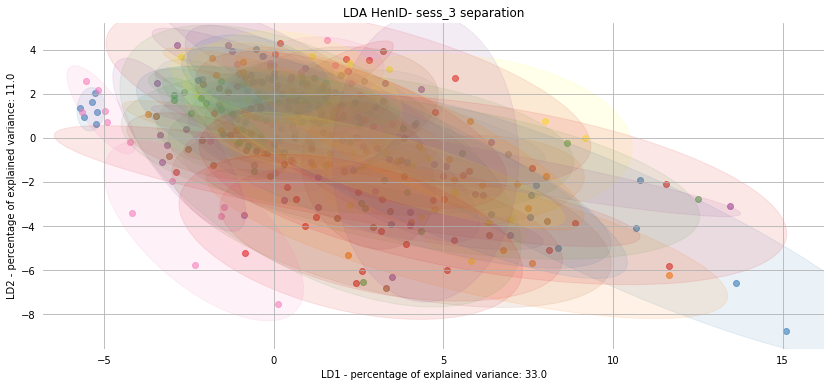

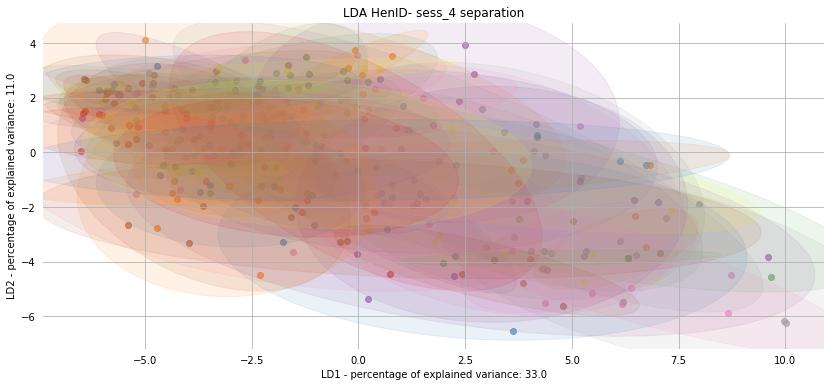

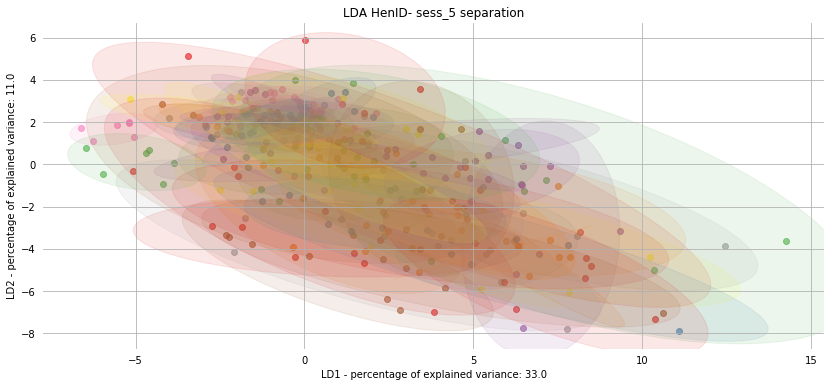

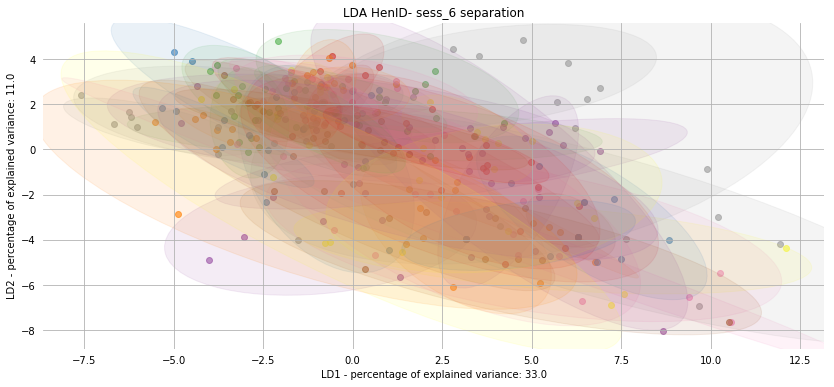

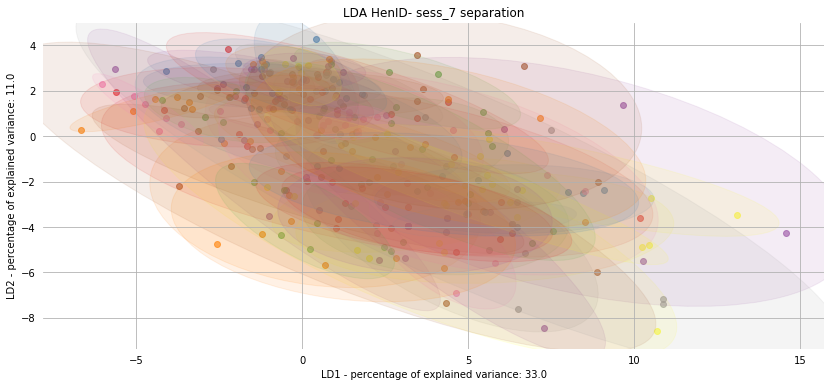

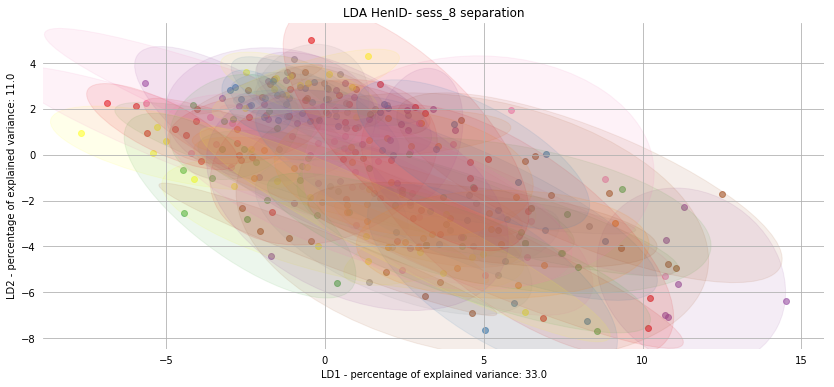

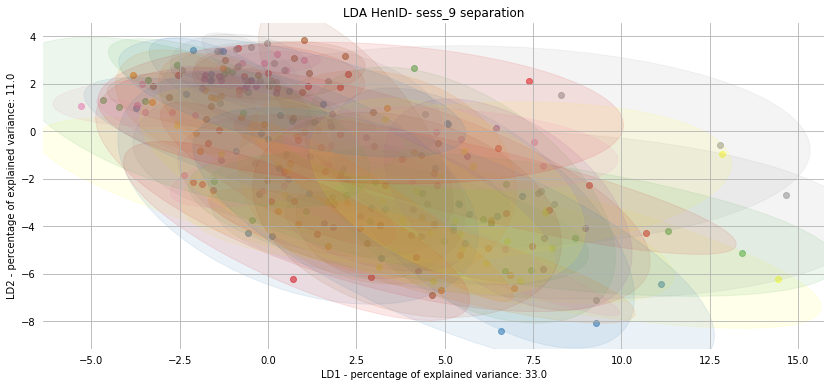

In [12]:
for sess, (X,y) in dico_sess_tXy.items():
    X_lda_sklearn = lda.transform(X)
    #plot with the first two component
    plot_scikit_lda(X_lda_sklearn, y, lda, 'LDA HenID- '+sess+' separation', path_save_LDA_LDA)

In [13]:
#plot ID1-sess1 vs ID1-sess2 etc: big sacterplot matrix: earlieast IDs should ideally have a significant correlation (add R2 
#on the plot) with all the remaining time
dico_h_dinfo = {}
for sess, (X,y) in dico_sess_tXy.items():
    X_lda_sklearn = lda.transform(X)
    for h in set(y):
        #points = np.array(list(zip(X[:,i][y==h] for i in range(nbr_lda_components))))
        for day_ in range(sum(y==h)):
            name_ = h+'_day_'+str(day_)
            if name_ not in dico_h_dinfo:
                dico_h_dinfo[name_] = {'HenID':h,'dayID':day_}
            for i in range(nbr_lda_components):
                dico_h_dinfo[name_][sess+'_ID'+str(i)] = list(X_lda_sklearn[:,i][y==h])[day_]
df_IDS = pd.DataFrame(list(dico_h_dinfo.values()))
print(df_IDS.shape)
df_IDS.head(3)

(360, 46)


,HenID,dayID,sess_10_ID0,sess_10_ID1,sess_10_ID2,sess_10_ID3,sess_11_ID0,sess_11_ID1,sess_11_ID2,sess_11_ID3,...,sess_7_ID2,sess_7_ID3,sess_8_ID0,sess_8_ID1,sess_8_ID2,sess_8_ID3,sess_9_ID0,sess_9_ID1,sess_9_ID2,sess_9_ID3
0,hen_58,0,0.994188,1.555722,-1.365706,1.232360,0.327578,2.229774,1.452901,-0.474615,...,-2.868646,2.231327,-1.082171,2.887536,-1.205473,-0.422416,0.244336,1.797748,2.697610,2.088459
1,hen_58,1,-0.602995,1.359728,-0.189257,2.570644,1.952286,0.234463,1.476686,0.301740,...,1.355897,1.748879,0.761246,2.234672,1.960379,0.396363,1.122732,1.913000,0.339091,2.391457
2,hen_58,2,-0.603789,2.105557,0.318372,0.484834,0.191013,1.824295,-2.005106,-0.106230,...,-0.405045,-0.136347,2.825425,2.097486,-0.805866,-1.368436,2.270823,2.390384,2.050393,1.977351


In [14]:
df_IDS[df_IDS['HenID']=='hen_41']

,HenID,dayID,sess_10_ID0,sess_10_ID1,sess_10_ID2,sess_10_ID3,sess_11_ID0,sess_11_ID1,sess_11_ID2,sess_11_ID3,...,sess_7_ID2,sess_7_ID3,sess_8_ID0,sess_8_ID1,sess_8_ID2,sess_8_ID3,sess_9_ID0,sess_9_ID1,sess_9_ID2,sess_9_ID3
192,hen_41,0,-1.811813,-2.506495,6.149561,1.382435,2.234925,-0.539951,-0.662695,-10.834307,...,-0.818874,-0.154909,-1.549315,3.359106,0.279196,-1.625203,0.518298,-0.980324,-1.211298,-5.159967
193,hen_41,1,6.336469,-3.253675,4.876984,3.524285,5.370023,-4.126709,3.330880,9.297301,...,-1.420908,0.135090,-2.500874,2.043266,2.403360,0.451982,4.450523,0.706696,-6.447324,-8.248398
194,hen_41,2,-0.192144,-3.460703,9.810859,-0.077709,0.467726,-0.639879,1.131532,-0.705646,...,0.789395,0.163672,0.862692,2.952230,2.514928,0.871521,1.747844,0.400527,2.053251,2.991025
195,hen_41,3,2.229461,-4.660870,4.425176,4.470493,8.117970,-4.298806,2.964033,5.552481,...,1.714666,1.003814,-0.536548,3.130877,1.495555,1.048525,-1.371126,1.175189,0.326570,-4.958144
196,hen_41,4,1.191065,-2.320249,5.565094,0.057177,8.228233,-6.013923,0.834537,4.601947,...,-0.032116,1.095408,1.354057,4.329283,-0.038336,-2.188536,0.167775,2.863154,-0.970566,-0.368946
197,hen_41,5,2.731637,-1.979094,5.548741,4.383200,8.474927,-3.620325,4.864005,7.107562,...,0.285369,-2.639674,-1.233891,2.590921,1.689177,-1.387058,0.098491,2.158814,-0.668760,0.414678


In [15]:
df_IDS[df_IDS['HenID']=='hen_91'][['sess_1_ID0','sess_1_ID1','sess_1_ID2','sess_1_ID3',
                                   'sess_10_ID0','sess_10_ID1','sess_10_ID2','sess_10_ID3',
                                   'sess_2_ID0','sess_2_ID1','sess_2_ID2','sess_2_ID3','dayID']]

,sess_1_ID0,sess_1_ID1,sess_1_ID2,sess_1_ID3,sess_10_ID0,sess_10_ID1,sess_10_ID2,sess_10_ID3,sess_2_ID0,sess_2_ID1,sess_2_ID2,sess_2_ID3,dayID
290,-5.378596,-1.144022,0.729516,-0.171434,NaN,NaN,NaN,NaN,-0.019464,-1.513838,1.708483,-1.562273,0
291,-2.843564,-0.647888,0.734437,1.320694,NaN,NaN,NaN,NaN,0.340814,-0.172150,4.263421,0.934323,1
292,-2.950277,-0.297280,-1.190599,0.585957,NaN,NaN,NaN,NaN,-1.533109,-1.432698,3.759165,4.576924,2
293,-3.519895,-0.888834,0.044294,2.175804,NaN,NaN,NaN,NaN,0.185261,-1.508297,2.640014,3.544327,3
294,-3.585019,-1.883424,1.251451,0.528781,NaN,NaN,NaN,NaN,0.546315,-1.767244,5.916251,4.370493,4
295,-2.383841,-0.881825,0.419613,0.390932,NaN,NaN,NaN,NaN,0.811790,-0.684460,-0.078303,-1.200285,5


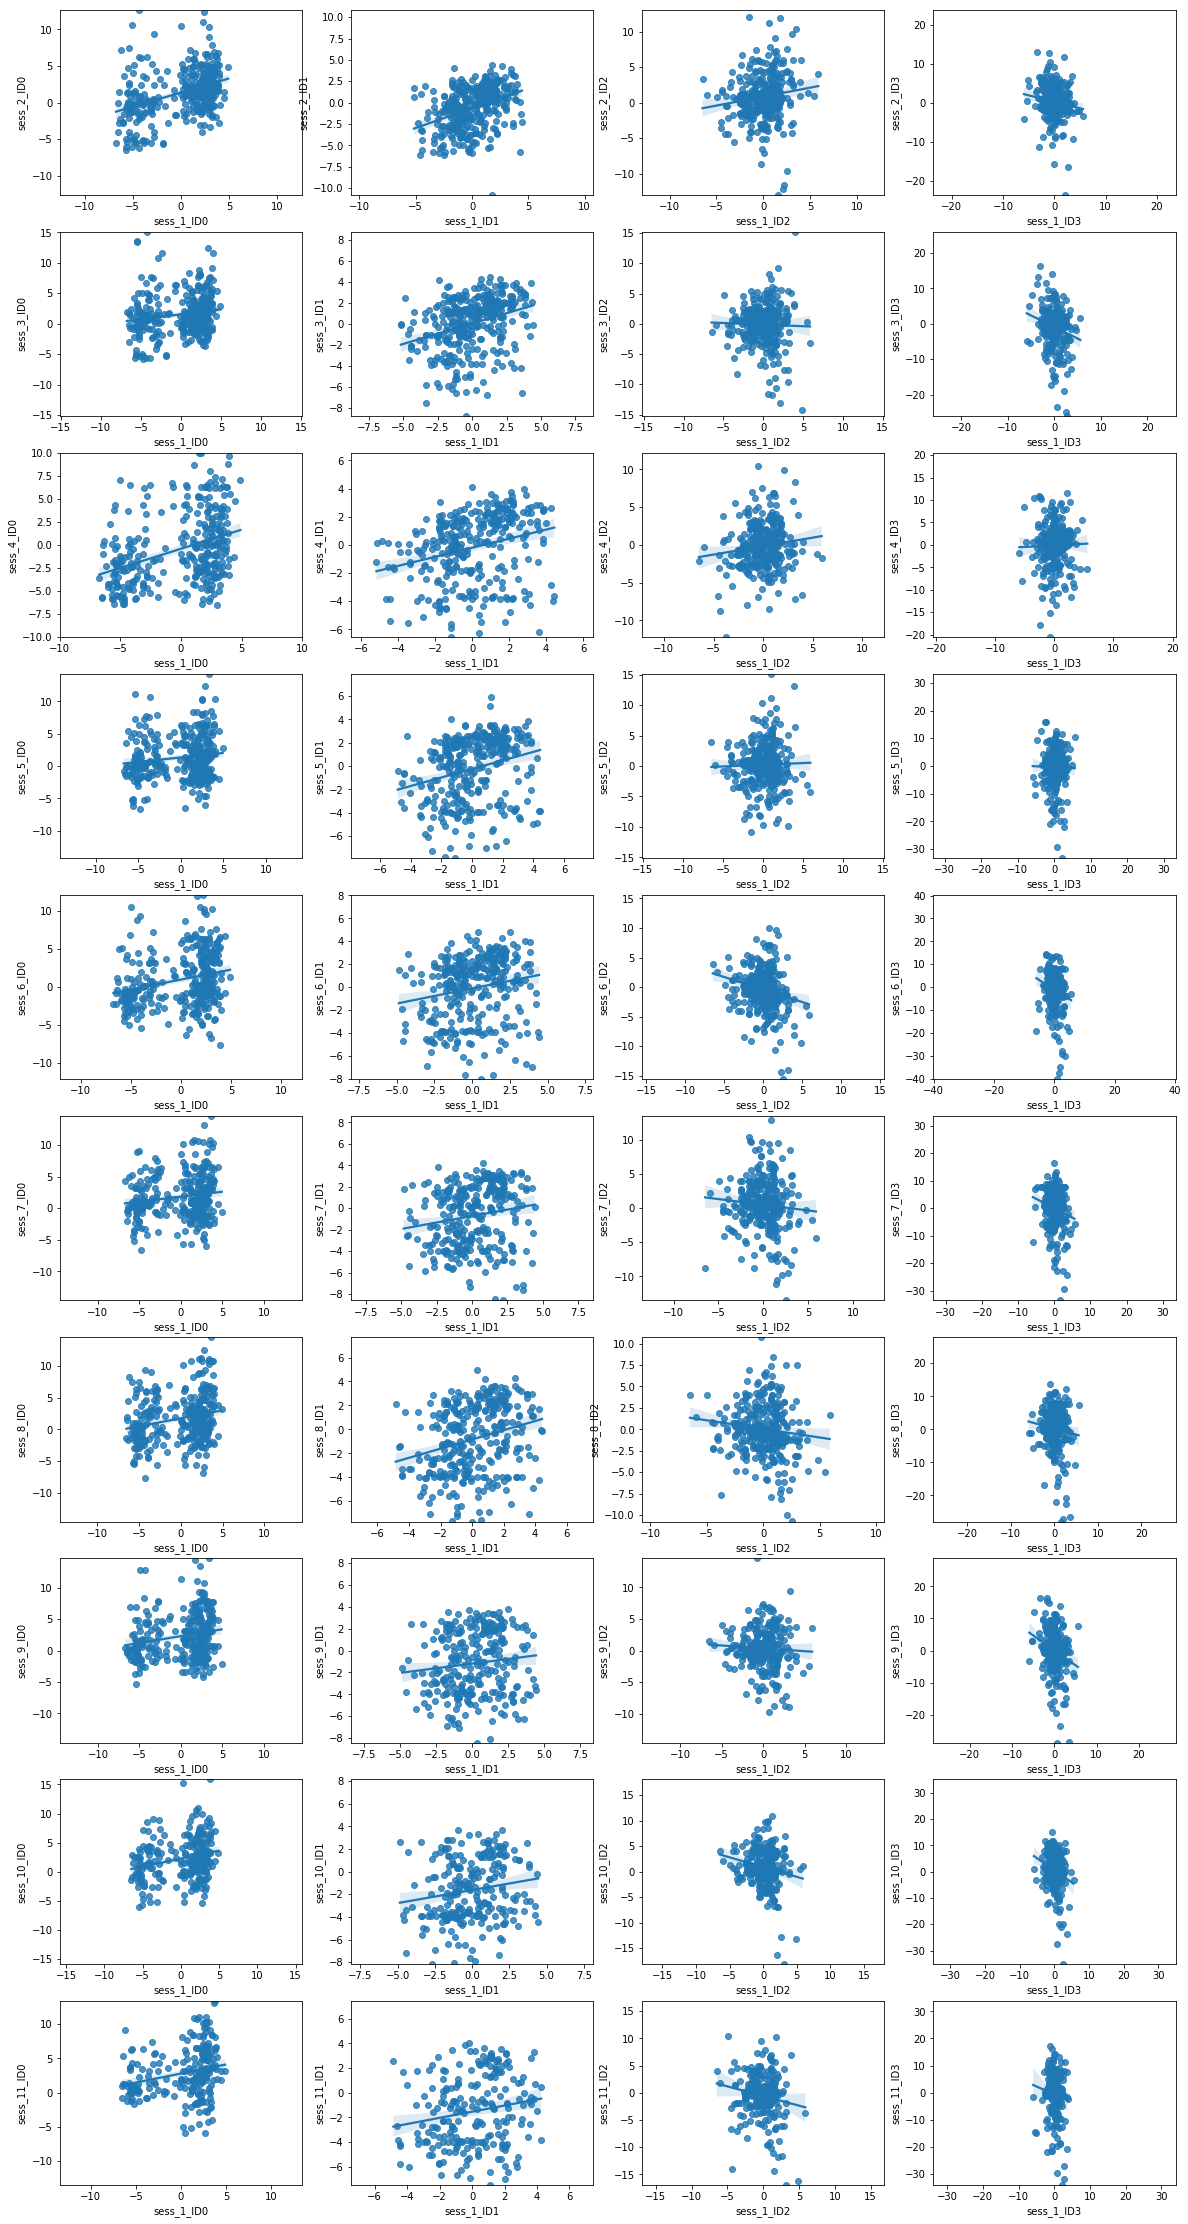

In [30]:
#TODO: is it and is it oke to comapre day x of each session together?
ncols = nbr_lda_components
nrows = 11
fig, axs = plt.subplots(ncols=ncols, nrows=(nrows-1), figsize=(ncols*5,(nrows-1)*4))
for id_ in range(nbr_lda_components):
    for sess in range(2,nrows+1):
        x = 'sess_1_ID'+str(id_)
        y = 'sess_'+str(sess)+'_ID'+str(id_)
        ax = sns.regplot(x=x, y=y, data=df_IDS, ax=axs[sess-2,id_]);
        v = max(abs(max(df_IDS[x].tolist())), abs(min(df_IDS[x].tolist())),
               abs(max(df_IDS[y].tolist())), abs(min(df_IDS[y].tolist())))
        ax.set(ylim=(-v, v))
        ax.set(xlim=(-v, v))
plt.savefig(os.path.join(path_save_LDA_LDA, 'IDS_consistency_over_time.png'),dpi=300,format='png',bbox_inches='tight')

# LDA comp explained variance

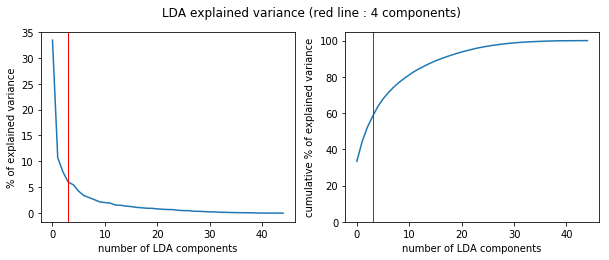

In [17]:
explained_var(lda, nbr_lda_components, path_save_LDA_LDA)

# LDA component & Expl. var

In [18]:
#small info on input/ouput shape
print('We have %d hens, %d observations (%d per class), %d expl. variables '%(len(set(y)), X.shape[0], X.shape[0]/len(set(y)),
                                                                               X.shape[1]))
#for each hen we have the coefficient/mean linked to each expl. variables
print(lda.coef_.shape, lda.means_.shape)
#for each expl. variables we ahve a row/column in the cov matrix
print(lda.covariance_.shape)
#for each of the n_components we have the explained_variance_ratio (by default its the min(n_classes - 1, n_features))
print(lda.explained_variance_ratio_.shape)

We have 47 hens, 281 observations (5 per class), 45 expl. variables 
(58, 45) (58, 45)
(45, 45)
(45,)


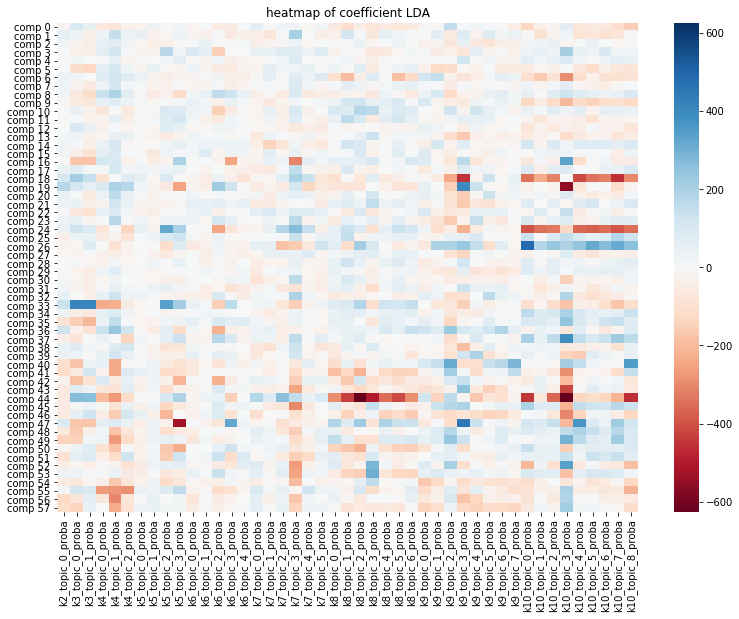

In [19]:
#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(13,9))
M = lda.coef_
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_t, yticklabels=['comp '+str(i) for i in range(lda.coef_.shape[0])],
            vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
plt.savefig(os.path.join(path_save_LDA_LDA, 'heatmap_coefficient_LDA_all_comp.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

(4, 45)


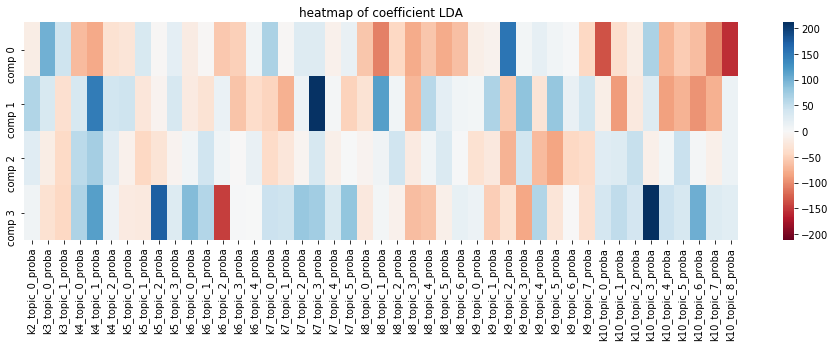

In [20]:
#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(16,4))
M = lda.coef_
M = M[0:nbr_lda_components,:]
print(M.shape)
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_t, yticklabels=['comp '+str(i) for i in range(M.shape[0])], vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
plt.savefig(os.path.join(path_save_LDA_LDA, 'heatmap_coefficient_LDA_first_comp.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

# Association with output

In [21]:
df_modelling[['HenID']+li_output].head(3)

,HenID,max_severity,max_positive_rate_in_severity,value_of_first_positive_rate_in_severity,var_severity,ratio_HealingAndNonhealing,"('Strength', 'variance')","('Strength', 'mean')","('Mass', 'variance')","('Mass', 'mean')","('Width', 'variance')","('Width', 'mean')"
0,hen_100,8.7,5.5,4.5,13.076529,0.166667,49.687500,42.750000,17.015000,63.200000,0.000600,0.320000
1,hen_101,9.8,3.6,2.5,8.417025,0.118421,6.240000,48.600000,1.240000,57.100000,0.000440,0.290000
2,hen_102,4.6,2.3,2.0,2.660165,0.393443,9.555556,49.666667,2.595556,62.666667,0.000156,0.343333


In [22]:
df_plot = pd.merge(df_IDS, df_modelling[['HenID']+li_output], on='HenID',how='inner')
print(df_IDS.shape, df_modelling.shape, df_plot.shape)
df_plot.head(3)

(360, 46) (57, 738) (342, 57)


,HenID,dayID,sess_10_ID0,sess_10_ID1,sess_10_ID2,sess_10_ID3,sess_11_ID0,sess_11_ID1,sess_11_ID2,sess_11_ID3,...,max_positive_rate_in_severity,value_of_first_positive_rate_in_severity,var_severity,ratio_HealingAndNonhealing,"('Strength', 'variance')","('Strength', 'mean')","('Mass', 'variance')","('Mass', 'mean')","('Width', 'variance')","('Width', 'mean')"
0,hen_58,0,0.994188,1.555722,-1.365706,1.232360,0.327578,2.229774,1.452901,-0.474615,...,4.3,4.3,4.971736,0.050847,26.24,50.4,8.0144,64.06,0.000456,0.338
1,hen_58,1,-0.602995,1.359728,-0.189257,2.570644,1.952286,0.234463,1.476686,0.301740,...,4.3,4.3,4.971736,0.050847,26.24,50.4,8.0144,64.06,0.000456,0.338
2,hen_58,2,-0.603789,2.105557,0.318372,0.484834,0.191013,1.824295,-2.005106,-0.106230,...,4.3,4.3,4.971736,0.050847,26.24,50.4,8.0144,64.06,0.000456,0.338


In [41]:
df_save = df_plot[['HenID','max_severity']+[x for x in df_plot.columns if 'sess_10_ID' in x]]
df_save.to_csv(os.path.join(path_save_LDA_LDA,'df_var.csv'), index=False, sep=';')

In [36]:
path_save_LDA_LDA

'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\visual\\LDA\\_LB_newword_def\\LDA'

In [23]:
#g = sns.regplot(x='max_severity', y="('Strength', 'variance')", data=df_plot, lowess=True);
#nothing

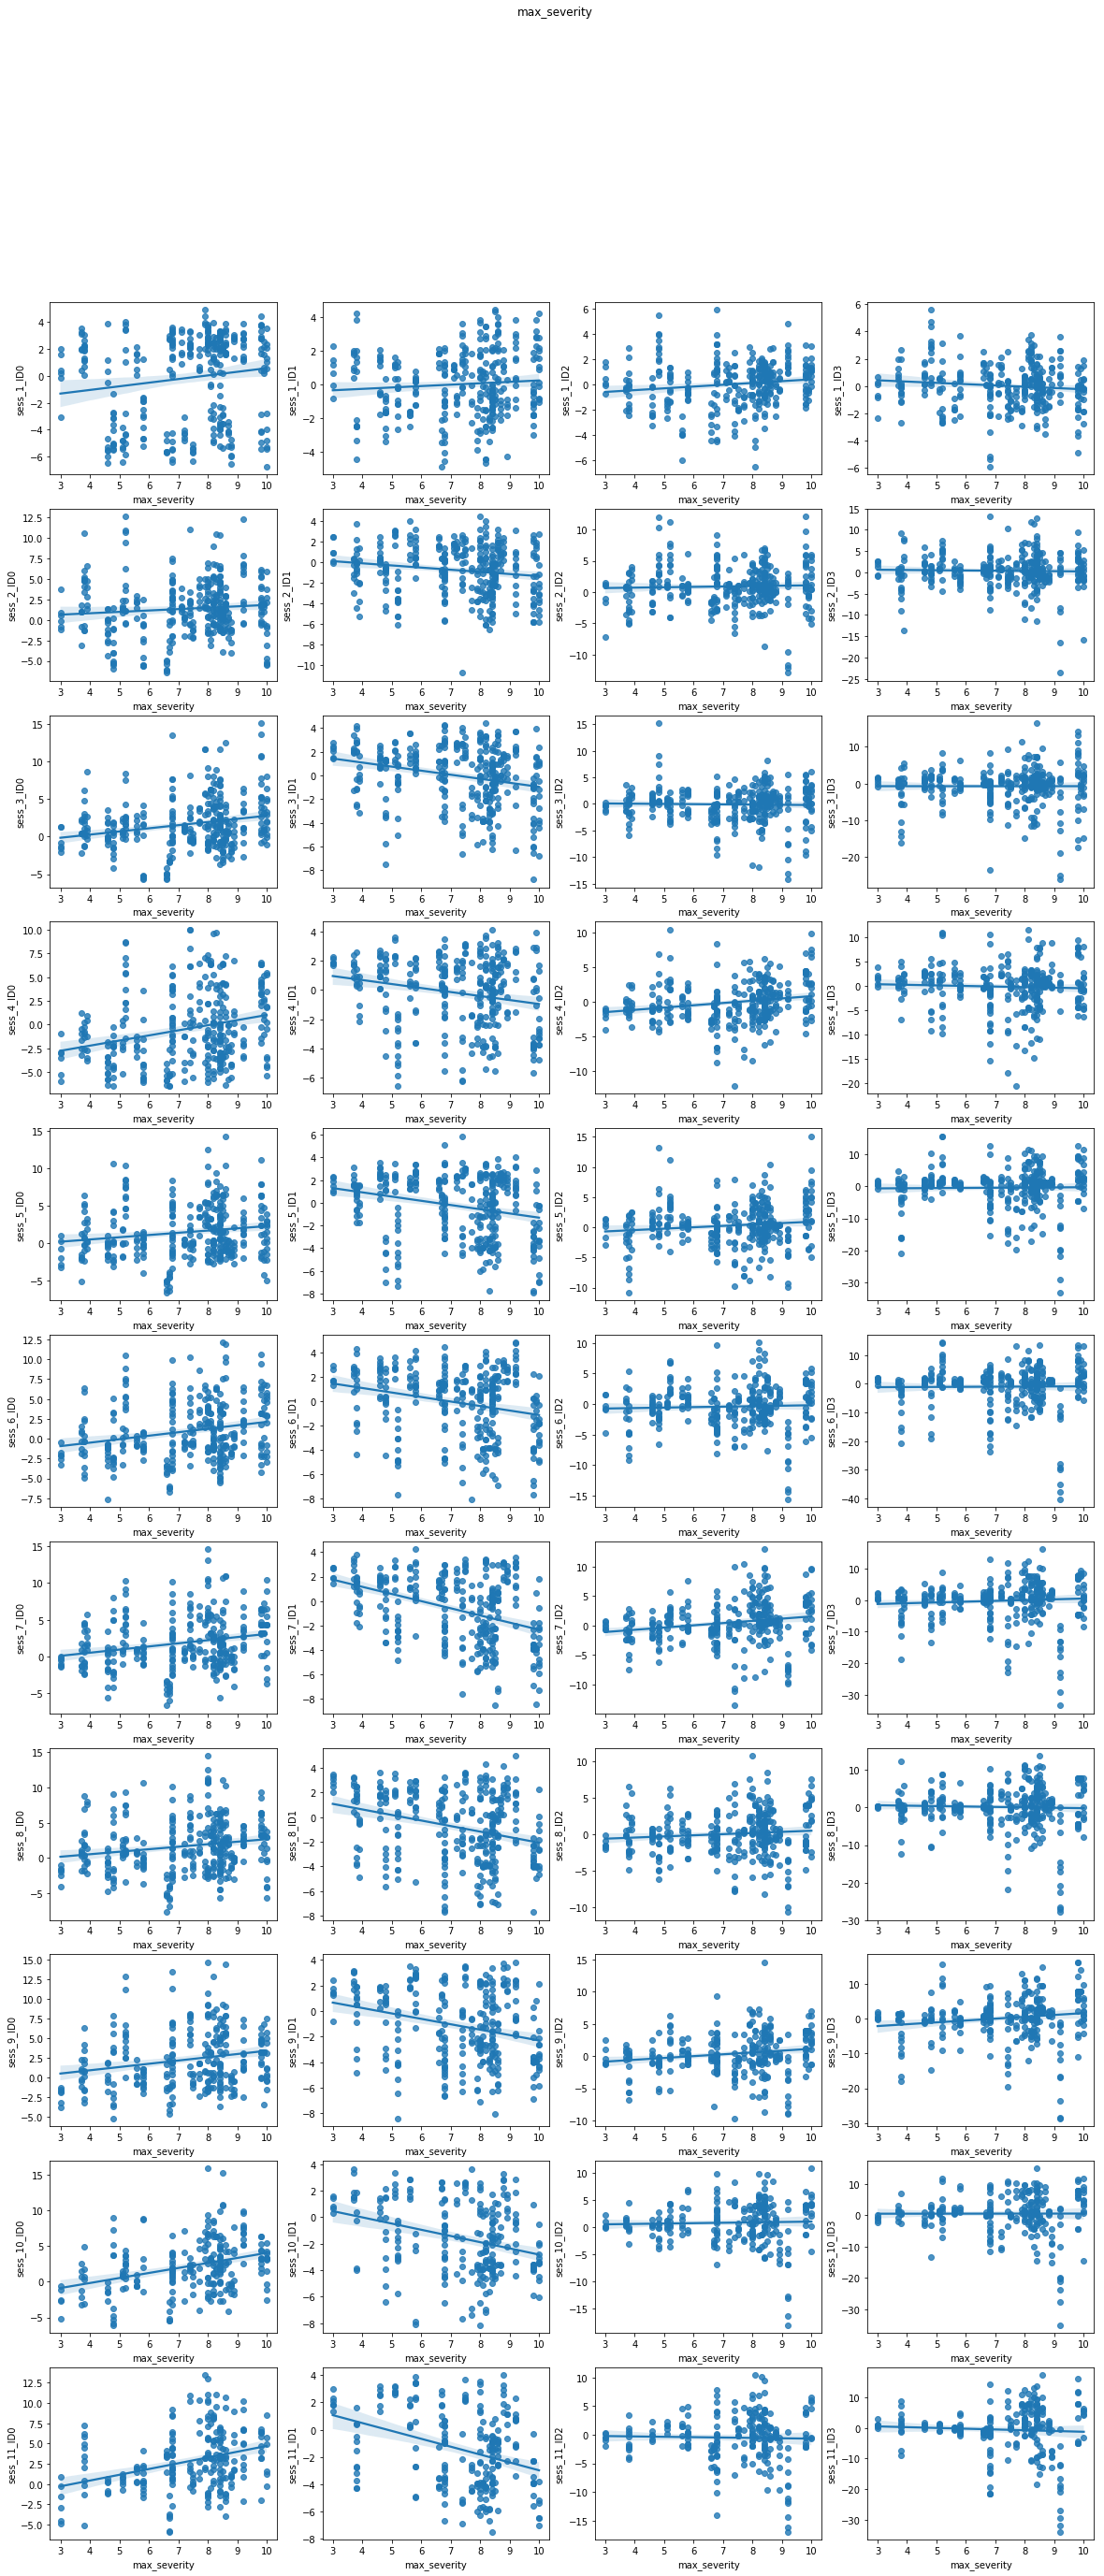

In [24]:
li_output = ['max_severity']
for output in li_output:
    ncols = nbr_lda_components
    nrows = 12
    fig, axs = plt.subplots(ncols=ncols, nrows=(nrows-1), figsize=(ncols*5,(nrows-1)*4))
    fig.suptitle(output) 
    for id_ in range(nbr_lda_components):
        for sess in range(1,nrows):
            g = sns.regplot(x=output, y='sess_'+str(sess)+'_ID'+str(id_), data=df_plot, ax=axs[sess-1,id_]);
    plt.savefig(os.path.join(path_save_LDA_LDA, 'IDs_associationWithOutput.png'),dpi=300,format='png',bbox_inches='tight')

# TODO